## Weather Report

In [60]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
gitdir = "/Users/magdalenaskrzycki/Desktop/GA2024_1/"

# Add the directory
module_path = os.path.abspath(gitdir)
sys.path.append(module_path)

from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

df_st = db.get_smartthings()
df_p1g = db.get_p1g()
df_weather = db.get_weather_data()

In [13]:
# temperature inside

df_ins_temp = df_st[df_st["capability"] == "temperatureMeasurement"]
df_ins_temp = df_ins_temp.copy()
df_ins_temp['value'] = df_ins_temp['value'].astype(float)
df_ins_temp.rename(columns={'value': 'inside temperature'}, inplace=True)
df_ins_temp['datetime'] = pd.to_datetime(df_ins_temp['epoch'], unit='s')
df_ins_temp.set_index('datetime', inplace=True)
df_avg_house_temp_hourly = df_ins_temp.resample('H').mean(numeric_only=True)
df_avg_house_temp_hourly.reset_index(inplace=True)
df_avg_house_temp_hourly = df_avg_house_temp_hourly[['datetime', 'inside temperature']]

## results in average inside temperature per hour in October 2022

In [14]:
# temperature outside

df_weather['temperature_2m'] = df_weather['temperature_2m'].astype(float)
df_out_temp = df_weather.copy()
df_out_temp.rename(columns={'temperature_2m': 'temperature'}, inplace=True)
df_out_temp['datetime'] = pd.to_datetime(df_out_temp['time'], unit='s')
df_target = df_out_temp[['datetime', 'temperature']]
df_target.set_index('datetime', inplace=True)
df_hourly_outside = df_target.resample('H').mean()
df_hourly_outside.reset_index(inplace=True)

# average per hour

In [54]:
df_p1g['total_gas_used'] = df_p1g['total_gas_used'].astype(float)
df_gas = df_p1g.copy()
df_gas = df_gas.dropna(subset=['total_gas_used'])
df_gas['datetime'] = pd.to_datetime(df_gas['time'])
df_target = df_gas[['datetime', 'total_gas_used']]
df_target.set_index('datetime', inplace=True)
df_first = df_target.resample('H').first()
df_last = df_target.resample('H').last()
df_last_shifted = df_last.shift(-1)
df_hourly_diff = df_last_shifted['total_gas_used'] - df_first['total_gas_used']
df_hourly_diff = df_hourly_diff.dropna()
df_hourly_diff = df_hourly_diff.reset_index()
df_hourly_diff.rename(columns={'total_gas_used': 'hourly_gas_difference'}, inplace=True)

In [55]:
df_merge = pd.merge(df_avg_house_temp_hourly, df_hourly_outside, on='datetime', how='inner')
df_final = pd.merge(df_merge, df_hourly_diff, on='datetime', how='inner')
df_final = df_final[['datetime','inside temperature', 'temperature','hourly_gas_difference']]
df = df_final

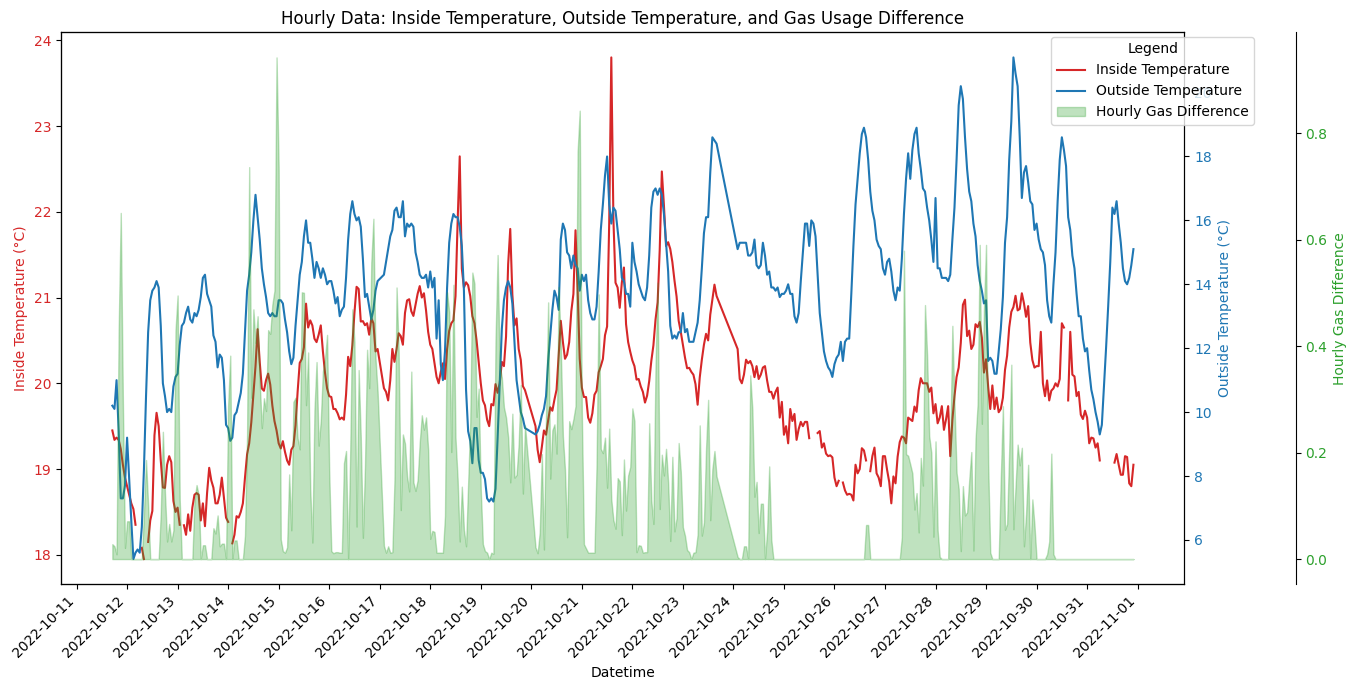

In [39]:
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Inside Temperature (°C)', color=color)
ax1.plot(df['datetime'], df['inside temperature'], color=color, label='Inside Temperature')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Outside Temperature (°C)', color=color)
ax2.plot(df['datetime'], df['temperature'], color=color, label='Outside Temperature')
ax2.tick_params(axis='y', labelcolor=color)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 80))
color = 'tab:green'
ax3.fill_between(df['datetime'], 0, df['hourly_gas_difference'], color=color, alpha=0.3, label='Hourly Gas Difference')
ax3.set_ylabel('Hourly Gas Difference', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # One tick per day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Just show date
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.75, 0.95), title="Legend")
plt.title('Hourly Data: Inside Temperature, Outside Temperature, and Gas Usage Difference')
fig.tight_layout() 
plt.subplots_adjust(right=0.85)  
plt.show()

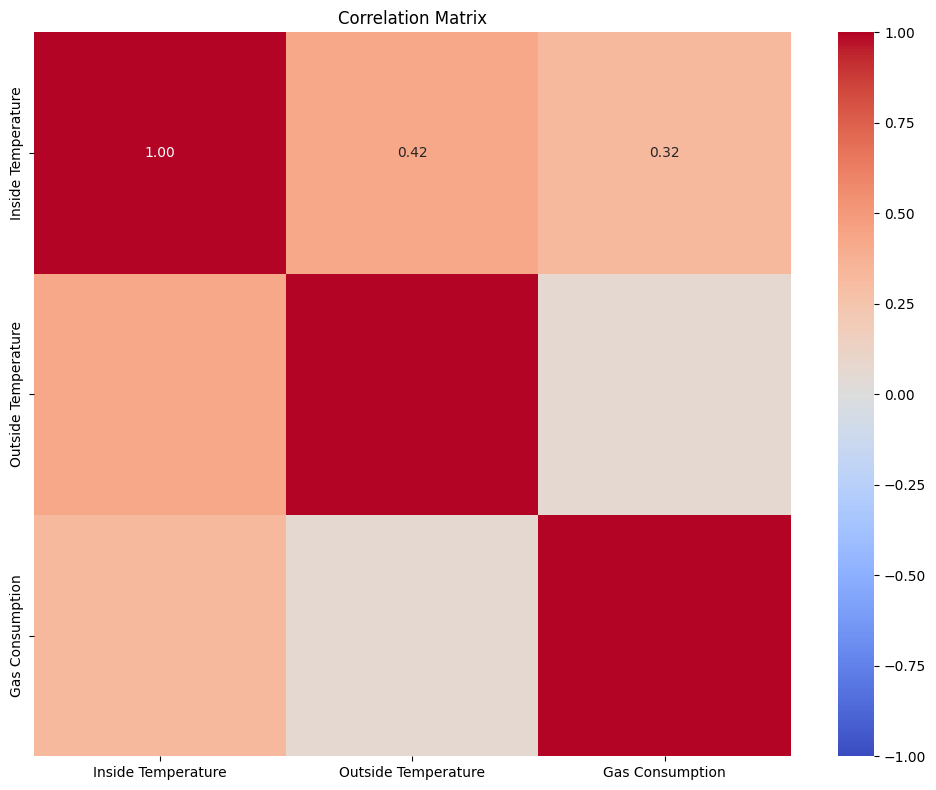

In [29]:
df_renamed = df.rename(columns={
    'inside temperature': 'Inside Temperature',
    'temperature': 'Outside Temperature',
    'hourly_gas_difference': 'Gas Consumption'
})
correlation_matrix = df_renamed[['Inside Temperature', 'Outside Temperature', 'Gas Consumption']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10}, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()  
plt.show()


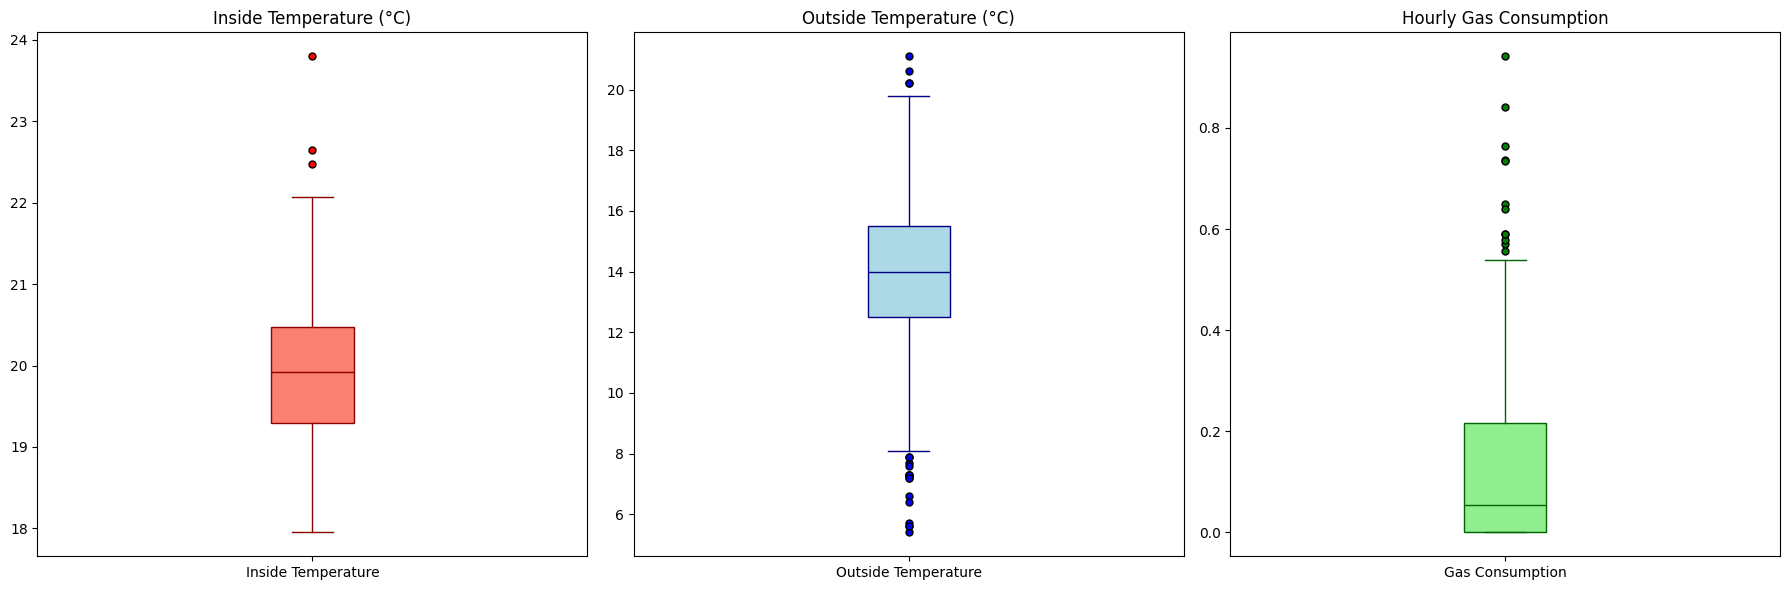

In [56]:
fig = plt.figure(figsize=(18, 6))

# Inside temperature plot
ax1 = fig.add_subplot(131)
ax1.boxplot(df['inside temperature'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='salmon', color='darkred'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='darkred'),
            capprops=dict(color='darkred'),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'))
ax1.set_title('Inside Temperature (°C)')
ax1.set_xticks([1])  
ax1.set_xticklabels(['Inside Temperature'])

# Outside temperature plot
ax2 = fig.add_subplot(132)
ax2.boxplot(df['temperature'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy'),
            medianprops=dict(color='navy'),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'),
            flierprops=dict(marker='o', markerfacecolor='blue', markersize=5, linestyle='none'))
ax2.set_title('Outside Temperature (°C)')
ax2.set_xticks([1]) 
ax2.set_xticklabels(['Outside Temperature'])

# Hourly gas difference plot
ax3 = fig.add_subplot(133)
ax3.boxplot(df['hourly_gas_difference'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='darkgreen'),
            whiskerprops=dict(color='darkgreen'),
            capprops=dict(color='darkgreen'),
            flierprops=dict(marker='o', markerfacecolor='green', markersize=5, linestyle='none'))
ax3.set_title('Hourly Gas Consumption')
ax3.set_xticks([1]) 
ax3.set_xticklabels(['Gas Consumption'])
plt.tight_layout()
plt.show()


In [58]:
df_clean = df.dropna(subset=['inside temperature', 'temperature', 'hourly_gas_difference'])
X = df_clean[['inside temperature', 'temperature']]  
X = sm.add_constant(X)  
y = df_clean['hourly_gas_difference']  
model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     hourly_gas_difference   R-squared:                       0.108
Model:                               OLS   Adj. R-squared:                  0.104
Method:                    Least Squares   F-statistic:                     27.51
Date:                   Thu, 06 Jun 2024   Prob (F-statistic):           5.30e-12
Time:                           01:45:17   Log-Likelihood:                 193.05
No. Observations:                    456   AIC:                            -380.1
Df Residuals:                        453   BIC:                            -367.7
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const 

In [53]:
df_clean = df[['inside temperature', 'temperature', 'hourly_gas_difference']].dropna()
df_clean['inside temperature'] = df_clean['inside temperature'].astype(float)
df_clean['temperature'] = df_clean['temperature'].astype(float)
df_clean['hourly_gas_difference'] = df_clean['hourly_gas_difference'].astype(float)
correlation_matrix = df_clean[['temperature', 'hourly_gas_difference']].corr()
print(correlation_matrix)
X = df_clean[['temperature', 'hourly_gas_difference']]
X = sm.add_constant(X)  
y = df_clean['inside temperature']
model = sm.OLS(y, X).fit()
print(model.summary())

                       temperature  hourly_gas_difference
temperature               1.000000               0.069998
hourly_gas_difference     0.069998               1.000000
                            OLS Regression Results                            
Dep. Variable:     inside temperature   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     81.71
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           5.00e-31
Time:                        01:34:37   Log-Likelihood:                -494.20
No. Observations:                 456   AIC:                             994.4
Df Residuals:                     453   BIC:                             1007.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    

In [61]:
# Independent t-test
inside_temp = df['inside temperature'].dropna()
outside_temp = df['temperature'].dropna()
t_stat_ind, p_value_ind = stats.ttest_ind(inside_temp, outside_temp)
print(f"Independent t-test - T-statistic: {t_stat_ind}, P-value: {p_value_ind}")
# Paired t-test
paired_data = df.dropna(subset=['inside temperature', 'temperature'])
inside_temp_paired = paired_data['inside temperature']
outside_temp_paired = paired_data['temperature']
t_stat_paired, p_value_paired = stats.ttest_rel(inside_temp_paired, outside_temp_paired)
print(f"Paired t-test - T-statistic: {t_stat_paired}, P-value: {p_value_paired}")

Independent t-test - T-statistic: 46.773759301398954, P-value: 5.678527570913212e-246
Paired t-test - T-statistic: 54.526081947273894, P-value: 1.192839814470349e-201
